## pystuff

Copy-and-paste references for time-series analysis with Python.

### Normal imports

In [4]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

### Import this module

In [5]:
import sys
sys.path.append('/home/zmaw/u241292/scripts/python/pystuff')
import pystuff as ps

### Read your data

In [30]:
# ERA-Interim SST anomalies, weighted by sqrt(cos(lat))
pathfile='/work/uo1075/u241292/data/ERAI/atmo/monavg_sst_w2_anom.nc'
ds=xr.open_dataset(pathfile)
lat=ds['lat'].values
lon=ds['lon'].values
myvar=ds['sst'].values
time=pd.to_datetime(ds['time'].values)

### Some time-series handling

Window given is even.
Using window=59 instead.
Window given is even.
Using window=59 instead.


/home/zmaw/u241292/scripts/python/pystuff/pystuff.py:486: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  annual=np.zeros((len(x)/12,))


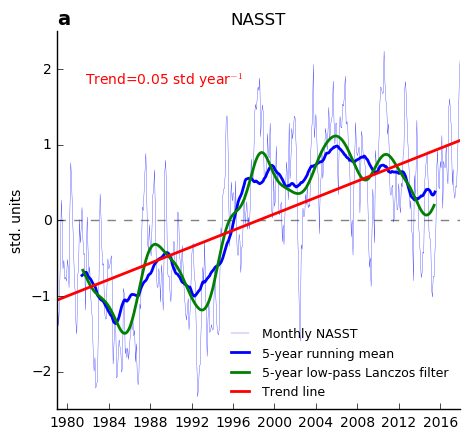

In [135]:
# Area Average
nasst, sasst_map = ps.getbox([0,60,280,360],lat,lon,myvar,returnmap=True)

# Standardize (center=True is default)
nasstn = ps.standardize(nasst)

# Running Mean
nasstn_rm = ps.runmean(nasstn,window=5*12)
nasstn_rm_fill = ps.runmean(nasstn,window=5*12,fillaround=True)

# Detrend (redundant with ddreg, to some extent)
# If returnTrend=False, only detended series is returned
nasstndt, slope, trend = ps.ddetrend(nasstn, returnTrend=True)

# The trend line can also be taken from:
trend2 = ps.ddreg(range(len(nasst)),nasst)

# Annual Mean
annual=ps.annualmean(nasstndt)

# Low-pass Lanczos Filter
dt=12 # month
cutoff=5 # years
low, low_nonan = ps.lanczos(nasstndt,dt*cutoff,returnNonan=True)

# Example Plot
fig = plt.figure(figsize=(9,4.5))

ax=fig.add_subplot(1,2,1)
ps.nospines(ax)
plt.axhline(0,color='grey',ls='--')
plt.plot(time,nasstn,'b',lw=0.2, label='Monthly NASST')
plt.plot(time,nasstn_rm,'b',lw=2, label='5-year running mean')
plt.plot(time,low+trend,'g',lw=2, label='5-year low-pass Lanczos filter')
plt.plot(time,trend,'-r', lw=2, label='Trend line')
plt.text(0.1,0.8,'Trend=%.2f std year$^{-1}$' %(float(slope)*12), color='r',
         transform=plt.gcf().transFigure)
plt.ylim((-2.5,2.5))
plt.ylabel('std. units')
plt.title('NASST')
plt.title('a', loc='left',fontweight='bold', fontsize=14)
ps.leg(loc='lower right', fontsize=9)

ps.usetex(False)
plt.tight_layout()
plt.show()

fig.savefig('/home/zmaw/u241292/scripts/python/pystuff/figs/timeseries.png')

### Periodogram

/home/zmaw/u241292/scripts/python/pystuff/pystuff.py:606: RuntimeWarning: divide by zero encountered in true_divide
  per=1/f


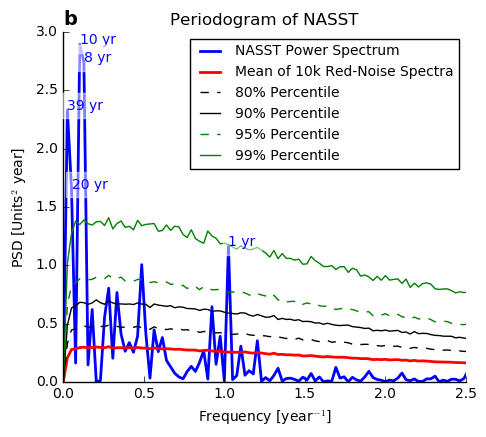

In [73]:
fig = plt.figure(figsize=(5,4.5))

ax=fig.add_subplot(111)
ps.nospines(ax)

# Calculate yearly periodogram on monthly data (Monte Carlo with 10k iterations)
f, psd, pctl, max5, meanRed = ps.periods(nasstndt, dt=12, nsim=10000)

plt.plot(f, psd,'b', lw=2, label='NASST Power Spectrum')
plt.plot(f,meanRed, 'r', lw=2, label='Mean of 10k Red-Noise Spectra')
plt.plot(f,pctl[:,0], '--k', label='80% Percentile')
plt.plot(f,pctl[:,1], '-k', label='90% Percentile')
plt.plot(f,pctl[:,2], '--g', label='95% Percentile')
plt.plot(f,pctl[:,3], '-g', label='99% Percentile')
plt.xlabel('Frequency [year$^{-1}$]')
plt.ylabel('PSD [Units$^{2}$ year]')
plt.xlim((0,2.5))
plt.title('Periodogram of NASST')
plt.title('b', loc='left',fontweight='bold', fontsize=14)
ps.leg(fontsize=10, frameon=True)

# Print maximum periods on graph
for i in range(5):
    t=plt.text(max5[i,0],max5[i,1],'%.0f yr' %round(max5[i,2]), color='blue')
    t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='w'))


plt.tight_layout()
plt.show()

fig.savefig('/home/zmaw/u241292/scripts/python/pystuff/figs/periodogram.png')

### PCA

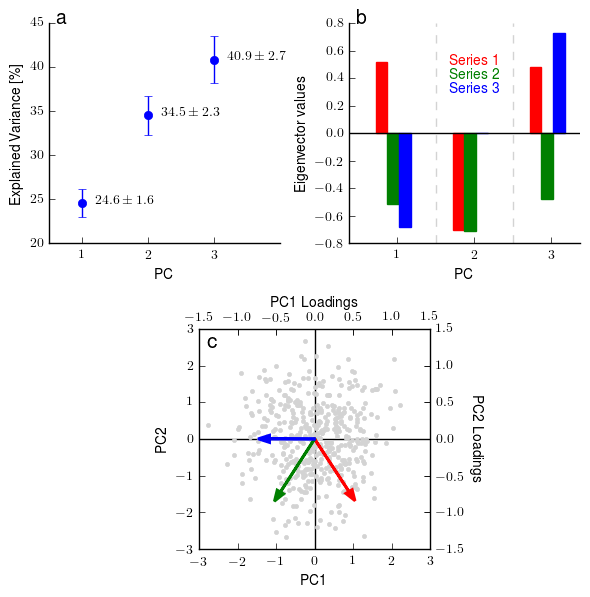

In [296]:
# Get data from any 3 grid cells
x1=myvar[:,100,100]
x2=myvar[:,100,200]
x3=myvar[:,100,300]
X=np.transpose([x1,x3,x2]) # np.shape(X) = (468, 3)

# Calculate PCA
scores, eigenvals, eigenvecs, expl, expl_acc, means, stds, north, loadings = ps.ddpca(X)

# Combo-plot
from matplotlib.gridspec import GridSpec
gs = GridSpec(nrows=2, ncols=4)
f=plt.figure(figsize=(6,6))

ax=f.add_subplot(gs[0, 0:2])
ps.usetex()
ps.nospines(ax)
plt.errorbar(np.arange(1,len(expl)+1),expl,yerr=[north,north], fmt='o',color='b',markeredgecolor='b')
for i in range(3):
    plt.text(i+1.2,expl[i],'$%.1f \pm %.1f$' %(expl[i],north[i]))
plt.xticks(np.arange(1,len(expl)+1,1))
plt.xlim((0.5,4))
plt.xlabel('PC')
plt.ylabel('Explained Variance [\%]')
plt.text(0.6,45,'a',fontsize=14,fontweight='heavy')

ax=f.add_subplot(gs[0, 2:])
ps.nospines(ax)
wdt=0.15
plt.axhline(0,color='k')
plt.bar(np.arange(3)-wdt,eigenvecs[0,:],facecolor='r',edgecolor='r',width=wdt)
plt.bar(np.arange(3)    ,eigenvecs[1,:],facecolor='g',edgecolor='g',width=wdt)
plt.bar(np.arange(3)+wdt,eigenvecs[2,:],facecolor='b',edgecolor='b',width=wdt)
plt.ylabel('Eigenvector values')
plt.xticks(np.arange(3)+0.125,['$1$','$2$','$3$'],usetex=True)
plt.xlabel('PC')
plt.axvline(0.625,color='lightgrey',ls='--')
plt.axvline(1.625,color='lightgrey',ls='--')
plt.text(0.8,0.5,'Series 1',color='r')
plt.text(0.8,0.4,'Series 2',color='g')
plt.text(0.8,0.3,'Series 3',color='b')
plt.text(-0.4,0.8,'b',fontsize=14,fontweight='heavy')

ax1=f.add_subplot(gs[1, 1:-1])
ax1.set_xlim((-3,3)); plt.ylim((-3,3))
ax1.set(xlabel='PC1', ylabel='PC2')
ax1.axvline(0,color='k')
ax1.axhline(0,color='k')
ax1.plot(scores[:,0],scores[:,1],'o',markersize=3,
         markeredgecolor='lightgrey',markerfacecolor='lightgrey')
ax1.text(-2.8,2.5,'c',fontsize=15,fontweight='heavy')
ax2 = ps.twinboth(ax1)
ax2.set_xlim((-1.5,1.5)); plt.ylim((-1.5,1.5))
ax2.set_xlabel('PC1 Loadings', labelpad=3)
ax2.set_ylabel('PC2 Loadings', labelpad=14)
ax2.arrow(0,0,loadings[0,0],loadings[0,1],width=0.005,color='r',lw=2)
ax2.arrow(0,0,loadings[1,0],loadings[1,1],width=0.005,color='g',lw=2)
ax2.arrow(0,0,loadings[2,0],loadings[2,1],width=0.005,color='b',lw=2)

plt.tight_layout()
plt.show()

f.savefig('/home/zmaw/u241292/scripts/python/pystuff/figs/pca.png')

### Fake Ensemble

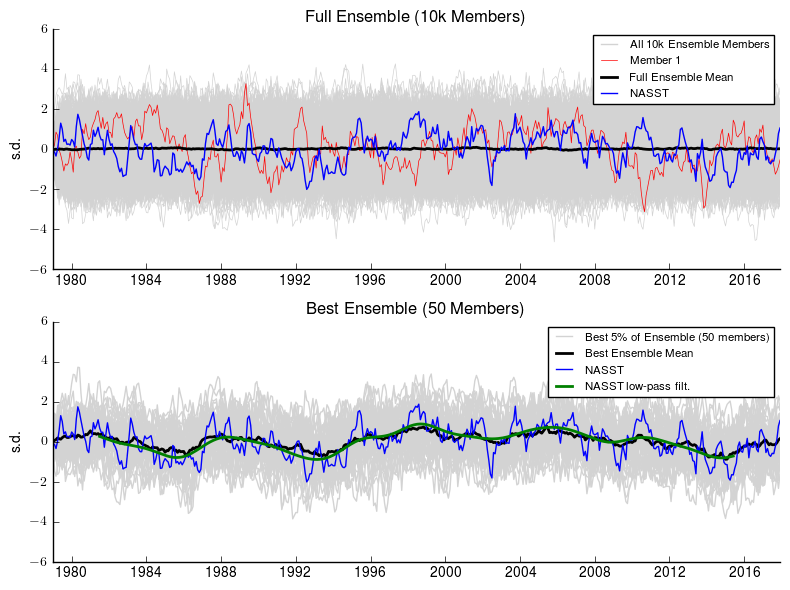

In [293]:
# Create a fake ensemble of nsim members of red noise (preserving the lag-dt) correlation
nsim=1000
dt=1
ens=ps.rednoise(len(nasstndt),ps.rhoAlt(nasstndt, dt=dt), nsim=nsim)

# Get Percentiles of Ensemble Spread
spread=ensPctl(ens,pctl=[0.025,0.975])

# Get the best 5% ensemble members, based on correlation
bestens, ensmean, nmembers = bestEns(ens,nasstndt,pctl=0.95)


# Plot
f=plt.figure(figsize=(8,6))

ax=f.add_subplot(2,1,1)
ps.nospines(ax)
plt.plot(time, ens,'lightgrey', lw=0.5)
# plt.fill_between(time, spread[:,0],spread[:,1],facecolor='k',alpha=0.1,label='2 std')
plt.plot(time, ens[:,1],'lightgrey', lw=1, label='All 10k Ensemble Members')
plt.plot(time, ens[:,1],'r', lw=0.5, label='Member 1')
plt.plot(time, np.nanmean(ens,axis=1),'k', lw=2, label='Full Ensemble Mean')
plt.plot(time, nasstndt,'b',lw=1,label='NASST')
plt.ylim((-6,6))
plt.ylabel('s.d.')
plt.title('Full Ensemble (10k Members)')
ps.leg(loc='upper right', frameon=True)

ax=f.add_subplot(2,1,2)
ps.nospines(ax)
plt.plot(time,bestens[:,0],'lightgrey', label='Best 5\% of Ensemble (50 members)')
plt.plot(time,bestens,'lightgrey')
plt.plot(time,ensmean,'k', lw=2, label='Best Ensemble Mean')
plt.plot(time,nasstndt,'b',lw=1,label='NASST')
plt.plot(time,low,'g',lw=2,label='NASST low-pass filt.')
plt.ylim((-6,6))
plt.ylabel('s.d.')
plt.title('Best Ensemble (50 Members)')
ps.leg(loc='upper right', frameon=True)

plt.tight_layout()
plt.show()
f.savefig('/home/zmaw/u241292/scripts/python/pystuff/figs/ensemeble.png')